# Quality control routines for PNBOIA

## Import libs

In [8]:
import pandas as pd
idx = pd.IndexSlice
%load_ext autoreload
%autoreload 2
import pnboia_qc.pnboia_limits as pnboia_limits
from pnboia_qc.qc_checks import QCChecks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load PNBOIA data

In [9]:
buoys_df = pd.read_csv('../raw_data/pnboia_raw_data.csv',parse_dates=True,index_col=['buoy','Datetime'])
buoys_df.rename(columns={'humi':'rh', # variables temporarily renamed to match QCChecks limits naming
                        'dewp':'dewpt',
                        'wtmp':'sst',
                        'cvel1':'cspd1',
                        'cvel2':'cspd2',
                        'cvel3':'cspd3',
                        'wvht':'swvht',
                        'wmax':'mxwvht',
                        'dpd':'tp',
                        'mwd':'wvdir'}, inplace=True)
buoys_df.drop(columns=['lat','lon'],inplace=True)

## Open limits for the data

In [10]:
mis_values = pnboia_limits.mis_value_axys_limits
limits = pnboia_limits.range_axys_limits
climate_limits = pnboia_limits.climate_axys_limits
stuck_limits = pnboia_limits.stuck_axys_limits
sigma_values = pnboia_limits.sigma_axys_limits
height = pnboia_limits.height
continuity_limit = pnboia_limits.continuity_axys_limits

## Create the class to start the qc tests

In [11]:
# Testing QCChecks for each buoy in the global DataFrame (buoys_df)
buoys = buoys_df.index.levels[0].unique()
for buoy in buoys:
    buoy_sel = buoys_df.loc[buoy].dropna(how='all',axis=1)
    variables = buoy_sel.columns.to_list()
    QCChecks(data=buoy_sel,
            variables=variables,
            mis_values=mis_values,
            limits=limits,
            climate_limits=climate_limits,
            stuck_limit=stuck_limits,
            sigma_values=sigma_values,
            continuity_limit=continuity_limit,
            height=height
            )
    print(f'qc object created successfully for {buoy}')
    

qc object created successfully for cf
qc object created successfully for cf2
qc object created successfully for fo
qc object created successfully for it
qc object created successfully for itaguai
qc object created successfully for itaoca
qc object created successfully for minuano
qc object created successfully for ni
qc object created successfully for ocas
qc object created successfully for po
qc object created successfully for re
qc object created successfully for rg
qc object created successfully for sa
qc object created successfully for vi


## 1. Boia Cabofrio

In [12]:
buoy = 'cf'
buoy_df = buoys_df.loc[buoy]
variables = buoy_df.columns.to_list()

qc = QCChecks(data=buoy_df,
        variables=variables,
        mis_values=mis_values,
        limits=limits,
        climate_limits=climate_limits,
        stuck_limit=stuck_limits,
        sigma_values=sigma_values,
        continuity_limit=continuity_limit,
        height=height
        )

### All tests

In [13]:
# Missvalue test
for parameter in mis_values.keys():
    qc_cf.mis_value_check(parameter=parameter)

# Range test
for parameter in limits.keys():
    qc_cf.range_check(parameter=parameter)

# Climate range test
for parameter in climate_limits.keys():
    qc_cf.range_check_climate(parameter=parameter)

# Comparison between swvht and mxwvht
qc_cf.swvht_mxwvht_check(swvht_name = 'swvht', mxwvht_name = 'mxwvht')

# Comparison of wind speed and gust
qc_cf.wind_speed_gust_check(wspd_name='wspd1', gust_name='gust1')
qc_cf.wind_speed_gust_check(wspd_name='wspd2', gust_name='gust2')

# Comparison of Dewpt and Atmp
qc_cf.dewpt_atmp_check(dewpt_name='dewpt', atmp_name='atmp')

# Comparison of battery and pressure
qc_cf.bat_sensor_check(battery_name='battery', pres_name='pres')

# Stuck sensor test
for parameter in variables:
    if parameter != 'battery':
        print(parameter)
        qc_cf.stuck_sensor_check(parameter=parameter)

# Convert wind to 10 meters
qc_cf.convert_10_meters(wspd_name='wspd1', gust_name='gust1')
qc_cf.convert_10_meters(wspd_name='wspd2', gust_name='gust2')

# Select the best anemometer
qc_cf.related_meas_check(parameters=['wspd1', 'wspd2', 'wdir1', 'wdir2', 'gust1', 'gust2'])

# Time continuity test
for parameter in sigma_values.keys():
    print(parameter)
    qc_cf.t_continuity_check(parameter=parameter)

# Front exception tests
qc_cf.front_except_check1(wdir_name='wdir', atmp_name='atmp')
qc_cf.front_except_check3(wspd_name='wspd', atmp_name='atmp')
qc_cf.front_except_check4(pres_name='pres', wspd_name='wspd')
qc_cf.front_except_check5(pres_name='pres')
qc_cf.frbont_except_check6(wspd_name='wspd', swvht_name='swvht')

/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[dewpt_name] == 51), dewpt_name] = self.data[atmp_name]


wspd1
gust1
wdir1
wspd2
gust2
wdir2
atmp
rh
dewpt
pres
sst
bhead
arad
cspd1
cdir1
cspd2
cdir2
cspd3
cdir3
swvht
mxwvht
tp
wvdir
spred


/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[wspd_name] == 0), wspd_name] = self.data[wspd_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[gust_name] == 0), gust_name] = self.data[gust_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

swvht
rh
pres
atmp
wspd
sst


/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_value["pres_new"] = select_value_2["pres"]


## 6. Boia Niteroi

In [26]:
buoy = 'ni'
buoy_df = buoys_df.loc[buoy]
variables = buoy_df.columns.to_list()

qc_ni = QCChecks(data=buoy_df,
        variables=variables,
        mis_values=mis_values,
        limits=limits,
        climate_limits=climate_limits,
        stuck_limit=stuck_limits,
        sigma_values=sigma_values,
        continuity_limit=continuity_limit,
        height=height
        )

### All tests

In [27]:
# Missvalue test
for parameter in mis_values.keys():
    qc_ni.mis_value_check(parameter=parameter)

# Range test
for parameter in limits.keys():
    qc_ni.range_check(parameter=parameter)

# Climate range test
for parameter in climate_limits.keys():
    qc_ni.range_check_climate(parameter=parameter)

# Comparison between swvht and mxwvht
qc_ni.swvht_mxwvht_check(swvht_name = 'swvht', mxwvht_name = 'mxwvht')

# Comparison of wind speed and gust
qc_ni.wind_speed_gust_check(wspd_name='wspd1', gust_name='gust1')
qc_ni.wind_speed_gust_check(wspd_name='wspd2', gust_name='gust2')

# Comparison of Dewpt and Atmp
qc_ni.dewpt_atmp_check(dewpt_name='dewpt', atmp_name='atmp')

# Comparison of battery and pressure
qc_ni.bat_sensor_check(battery_name='battery', pres_name='pres')

# Stuck sensor test
for parameter in variables:
    if parameter != 'battery':
        print(parameter)
        qc_ni.stuck_sensor_check(parameter=parameter)

# Convert wind to 10 meters
qc_ni.convert_10_meters(wspd_name='wspd1', gust_name='gust1')
qc_ni.convert_10_meters(wspd_name='wspd2', gust_name='gust2')

# Select the best anemometer
qc_ni.related_meas_check(parameters=['wspd1', 'wspd2', 'wdir1', 'wdir2', 'gust1', 'gust2'])

# Time continuity test
for parameter in sigma_values.keys():
    print(parameter)
    qc_ni.t_continuity_check(parameter=parameter)

# Front exception tests
qc_ni.front_except_check1(wdir_name='wdir', atmp_name='atmp')
qc_ni.front_except_check3(wspd_name='wspd', atmp_name='atmp')
qc_ni.front_except_check4(pres_name='pres', wspd_name='wspd')
qc_ni.front_except_check5(pres_name='pres')
qc_ni.front_except_check6(wspd_name='wspd', swvht_name='swvht')

/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[dewpt_name] == 51), dewpt_name] = self.data[atmp_name]


wspd1
gust1
wdir1
wspd2
gust2
wdir2
atmp
rh
dewpt
pres
sst
bhead
arad
cspd1
cdir1
cspd2
cdir2
cspd3
cdir3
swvht
mxwvht
tp
wvdir
spred


/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[wspd_name] == 0), wspd_name] = self.data[wspd_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[gust_name] == 0), gust_name] = self.data[gust_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

swvht
rh
pres
atmp
wspd
sst


/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_value["pres_new"] = select_value_2["pres"]
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_value["pres_new"] = select_value_2["pres"]


## 10. Boia Fortaleza

In [28]:
buoy = 'fo'
buoy_df = buoys_df.loc[buoy]
variables = buoy_df.columns.to_list()

qc_fo = QCChecks(data=buoy_df,
        variables=variables,
        mis_values=mis_values,
        limits=limits,
        climate_limits=climate_limits,
        stuck_limit=stuck_limits,
        sigma_values=sigma_values,
        continuity_limit=continuity_limit,
        height=height
        )

### All tests

In [29]:
# Missvalue test
for parameter in mis_values.keys():
    qc_fo.mis_value_check(parameter=parameter)

# Range test
for parameter in limits.keys():
    qc_fo.range_check(parameter=parameter)

# Climate range test
for parameter in climate_limits.keys():
    qc_fo.range_check_climate(parameter=parameter)

# Comparison between swvht and mxwvht
qc_fo.swvht_mxwvht_check(swvht_name = 'swvht', mxwvht_name = 'mxwvht')

# Comparison of wind speed and gust
qc_fo.wind_speed_gust_check(wspd_name='wspd1', gust_name='gust1')
qc_fo.wind_speed_gust_check(wspd_name='wspd2', gust_name='gust2')

# Comparison of Dewpt and Atmp
qc_fo.dewpt_atmp_check(dewpt_name='dewpt', atmp_name='atmp')

# Comparison of battery and pressure
qc_fo.bat_sensor_check(battery_name='battery', pres_name='pres')

# Stuck sensor test
for parameter in variables:
    if parameter != 'battery':
        print(parameter)
        qc_fo.stuck_sensor_check(parameter=parameter)

# Convert wind to 10 meters
qc_fo.convert_10_meters(wspd_name='wspd1', gust_name='gust1')
qc_fo.convert_10_meters(wspd_name='wspd2', gust_name='gust2')

# Select the best anemometer
qc_fo.related_meas_check(parameters=['wspd1', 'wspd2', 'wdir1', 'wdir2', 'gust1', 'gust2'])

# Time continuity test
for parameter in sigma_values.keys():
    print(parameter)
    qc_fo.t_continuity_check(parameter=parameter)

# Front exception tests
qc_fo.front_except_check1(wdir_name='wdir', atmp_name='atmp')
qc_fo.front_except_check3(wspd_name='wspd', atmp_name='atmp')
qc_fo.front_except_check4(pres_name='pres', wspd_name='wspd')
qc_fo.front_except_check5(pres_name='pres')
qc_fo.front_except_check6(wspd_name='wspd', swvht_name='swvht')

/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[dewpt_name] == 51), dewpt_name] = self.data[atmp_name]


wspd1
gust1
wdir1
wspd2
gust2
wdir2
atmp
rh
dewpt
pres
sst
bhead
arad
cspd1
cdir1
cspd2
cdir2
cspd3
cdir3
swvht
mxwvht
tp
wvdir
spred


/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[wspd_name] == 0), wspd_name] = self.data[wspd_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[gust_name] == 0), gust_name] = self.data[gust_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

swvht
rh
pres
atmp
wspd
sst


## 10. Boia Itaoca

In [32]:
buoy = 'itaoca'
buoy_df = buoys_df.loc[buoy]
variables = buoy_df.columns.to_list()

qc_itaoca = QCChecks(data=buoy_df,
        variables=variables,
        mis_values=mis_values,
        limits=limits,
        climate_limits=climate_limits,
        stuck_limit=stuck_limits,
        sigma_values=sigma_values,
        continuity_limit=continuity_limit,
        height=height
        )

### All tests

In [33]:
# Missvalue test
for parameter in mis_values.keys():
    qc_itaoca.mis_value_check(parameter=parameter)

# Range test
for parameter in limits.keys():
    qc_itaoca.range_check(parameter=parameter)

# Climate range test
for parameter in climate_limits.keys():
    qc_itaoca.range_check_climate(parameter=parameter)

# Comparison between swvht and mxwvht
qc_itaoca.swvht_mxwvht_check(swvht_name = 'swvht', mxwvht_name = 'mxwvht')

# Comparison of wind speed and gust
qc_itaoca.wind_speed_gust_check(wspd_name='wspd1', gust_name='gust1')
qc_itaoca.wind_speed_gust_check(wspd_name='wspd2', gust_name='gust2')

# Comparison of Dewpt and Atmp
qc_itaoca.dewpt_atmp_check(dewpt_name='dewpt', atmp_name='atmp')

# Comparison of battery and pressure
qc_itaoca.bat_sensor_check(battery_name='battery', pres_name='pres')

# Stuck sensor test
for parameter in variables:
    if parameter != 'battery':
        print(parameter)
        qc_itaoca.stuck_sensor_check(parameter=parameter)

# Convert wind to 10 meters
qc_itaoca.convert_10_meters(wspd_name='wspd1', gust_name='gust1')
qc_itaoca.convert_10_meters(wspd_name='wspd2', gust_name='gust2')

# Select the best anemometer
qc_itaoca.related_meas_check(parameters=['wspd1', 'wspd2', 'wdir1', 'wdir2', 'gust1', 'gust2'])

# Time continuity test
for parameter in sigma_values.keys():
    print(parameter)
    qc_itaoca.t_continuity_check(parameter=parameter)

# Front exception tests
qc_itaoca.front_except_check1(wdir_name='wdir', atmp_name='atmp')
qc_itaoca.front_except_check3(wspd_name='wspd', atmp_name='atmp')
qc_itaoca.front_except_check4(pres_name='pres', wspd_name='wspd')
qc_itaoca.front_except_check5(pres_name='pres')
qc_itaoca.front_except_check6(wspd_name='wspd', swvht_name='swvht')

/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[dewpt_name] == 51), dewpt_name] = self.data[atmp_name]


wspd1
gust1
wdir1
wspd2
gust2
wdir2
atmp
rh
dewpt
pres
sst
bhead
arad
cspd1
cdir1
cspd2
cdir2
cspd3
cdir3
swvht
mxwvht
tp
wvdir
spred


/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[wspd_name] == 0), wspd_name] = self.data[wspd_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.loc[(self.flag[gust_name] == 0), gust_name] = self.data[gust_name] * (10 / height) ** 0.11
/home/remobs-dados/pnboia_qc/pnboia_qc/qc_checks.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

swvht
rh
pres
atmp
wspd
sst


In [36]:
qc_itaoca.flag.sum()

battery       0
wspd1      1096
gust1         0
wdir1         0
wspd2         0
gust2         0
wdir2         0
atmp          0
rh            0
dewpt         0
pres         10
sst           0
bhead         0
arad          0
cspd1        32
cdir1         0
cspd2         0
cdir2         0
cspd3         0
cdir3         0
swvht        24
mxwvht       24
tp            0
wvdir         0
spred         0
wspd          0
wdir          0
gust          0
dtype: int64

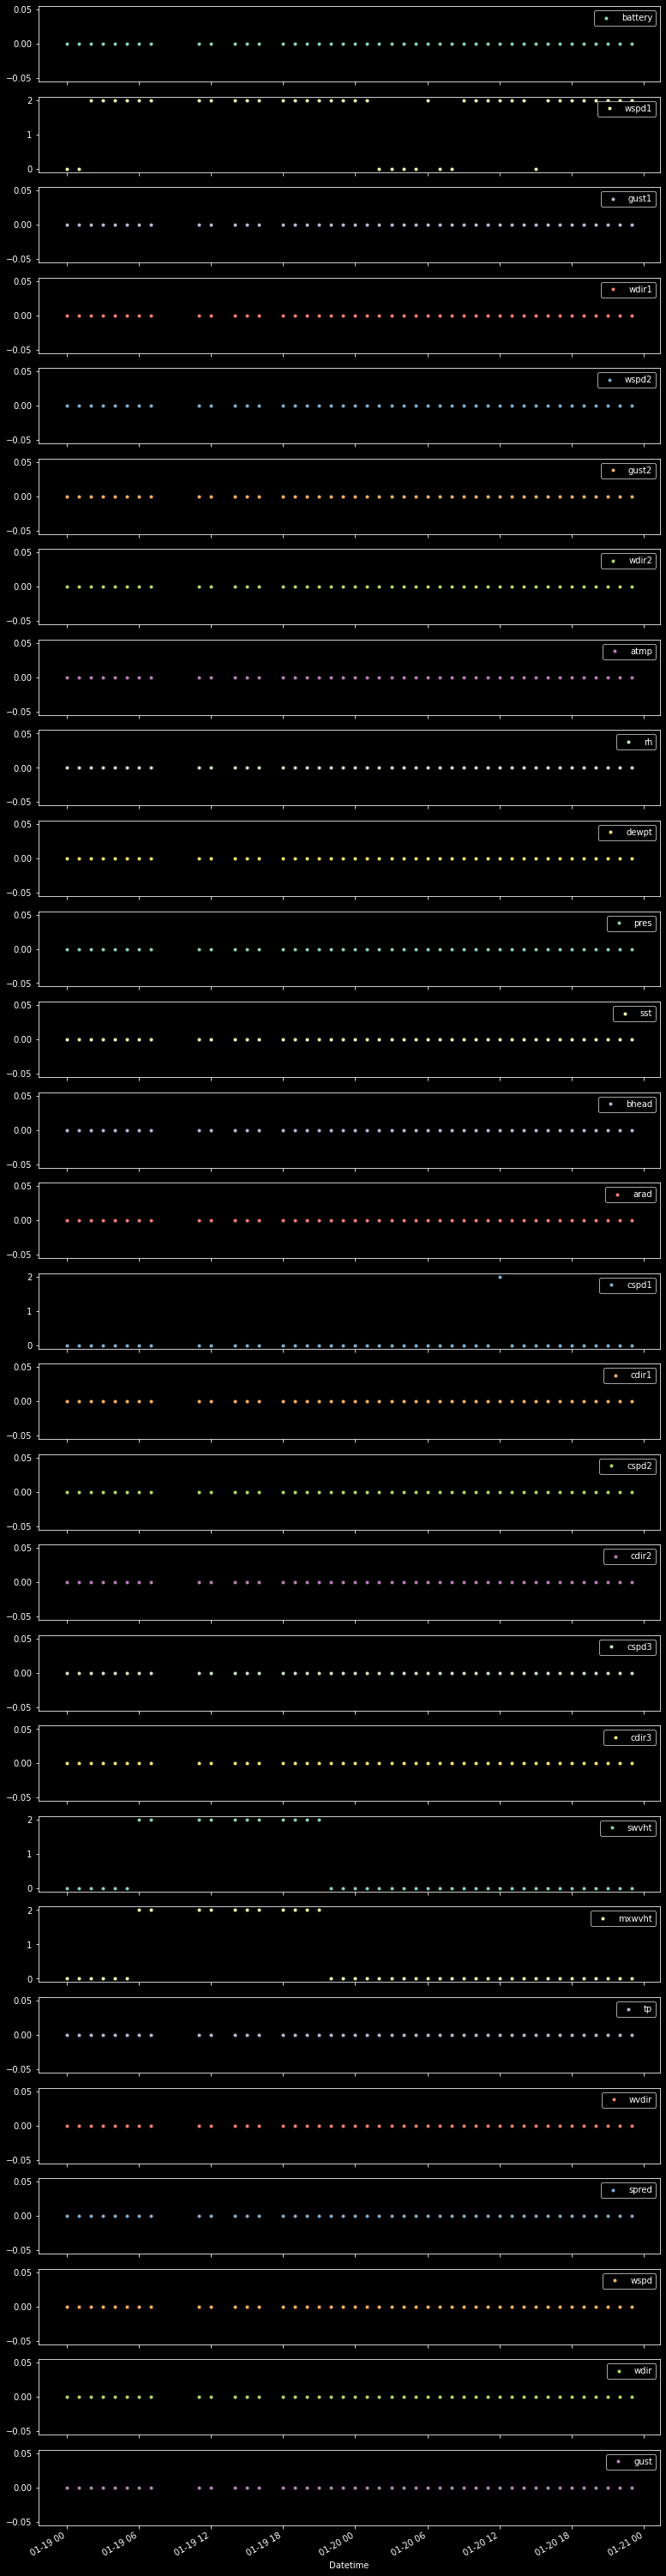

In [72]:
qc_itaoca.flag.loc['2019-01-19':'2019-01-20'].plot(subplots=True,marker='.',ls='none',figsize=(13,60));

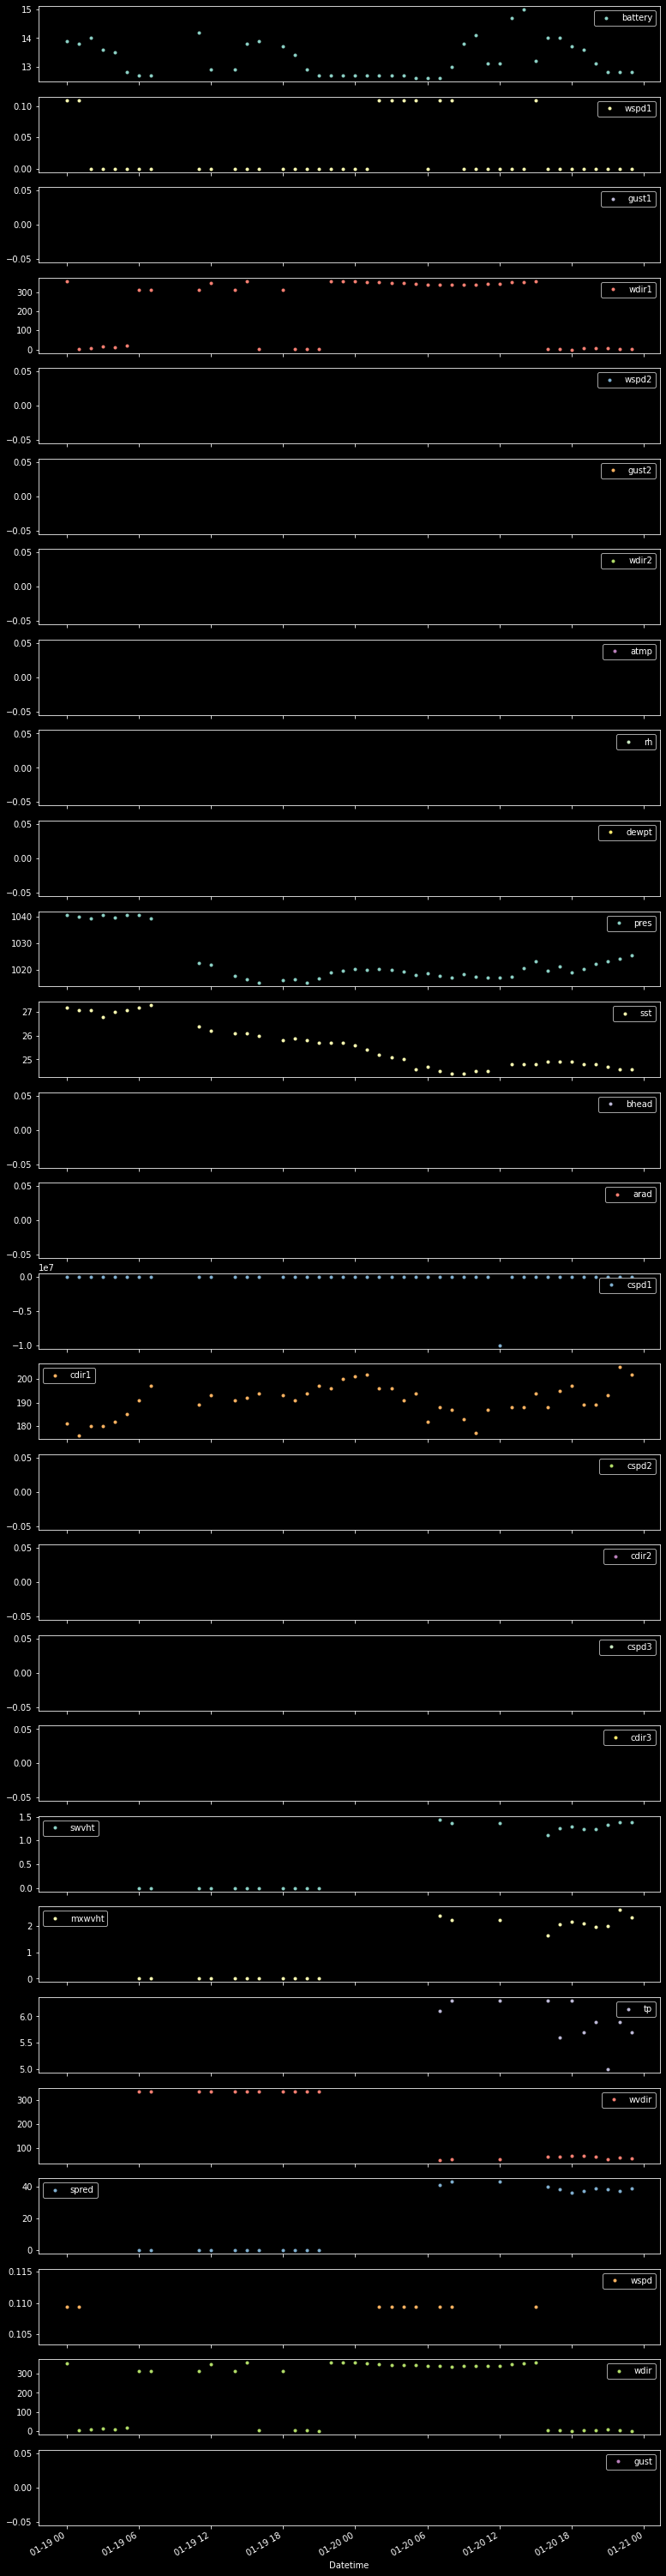

In [68]:
qc_itaoca.data.loc['2019-01-19':'2019-01-20'].plot(subplots=True,marker='.',ls='none',figsize=(13,60));

In [39]:
import numpy as np

In [83]:
def filter_data(qc_object):
    filtered_bad_data = pd.DataFrame(index=qc_object.data.index,columns=qc_object.data.columns)
    parameters = qc_object.data.columns
    for parameter in parameters:
        bool_array = np.logical_and(qc_object.flag[parameter]<1, qc_object.flag[parameter]>=0)
        bool_array_2 = ~np.logical_and(qc_object.flag[parameter]>0, qc_object.flag[parameter]<100)

        filtered_param = qc_object.data[parameter][bool_array]
        filtered_bad_param = qc_object.data[parameter][bool_array_2]

        filtered_bad_data[parameter] = filtered_bad_param
    
    return bool_array_2


In [109]:
def filter_data(qc_object):
    filtered_bad_data = pd.DataFrame(index=qc_object.data.index,columns=qc_object.data.columns)
    bool_array_2 = np.logical_and(qc_object.flag>0, qc_object.flag<100)
    filtered_bad_data = qc_object.data[~bool_array_2]

    return filtered_bad_data


In [110]:
itaoca_filtered = filter_data(qc_itaoca)

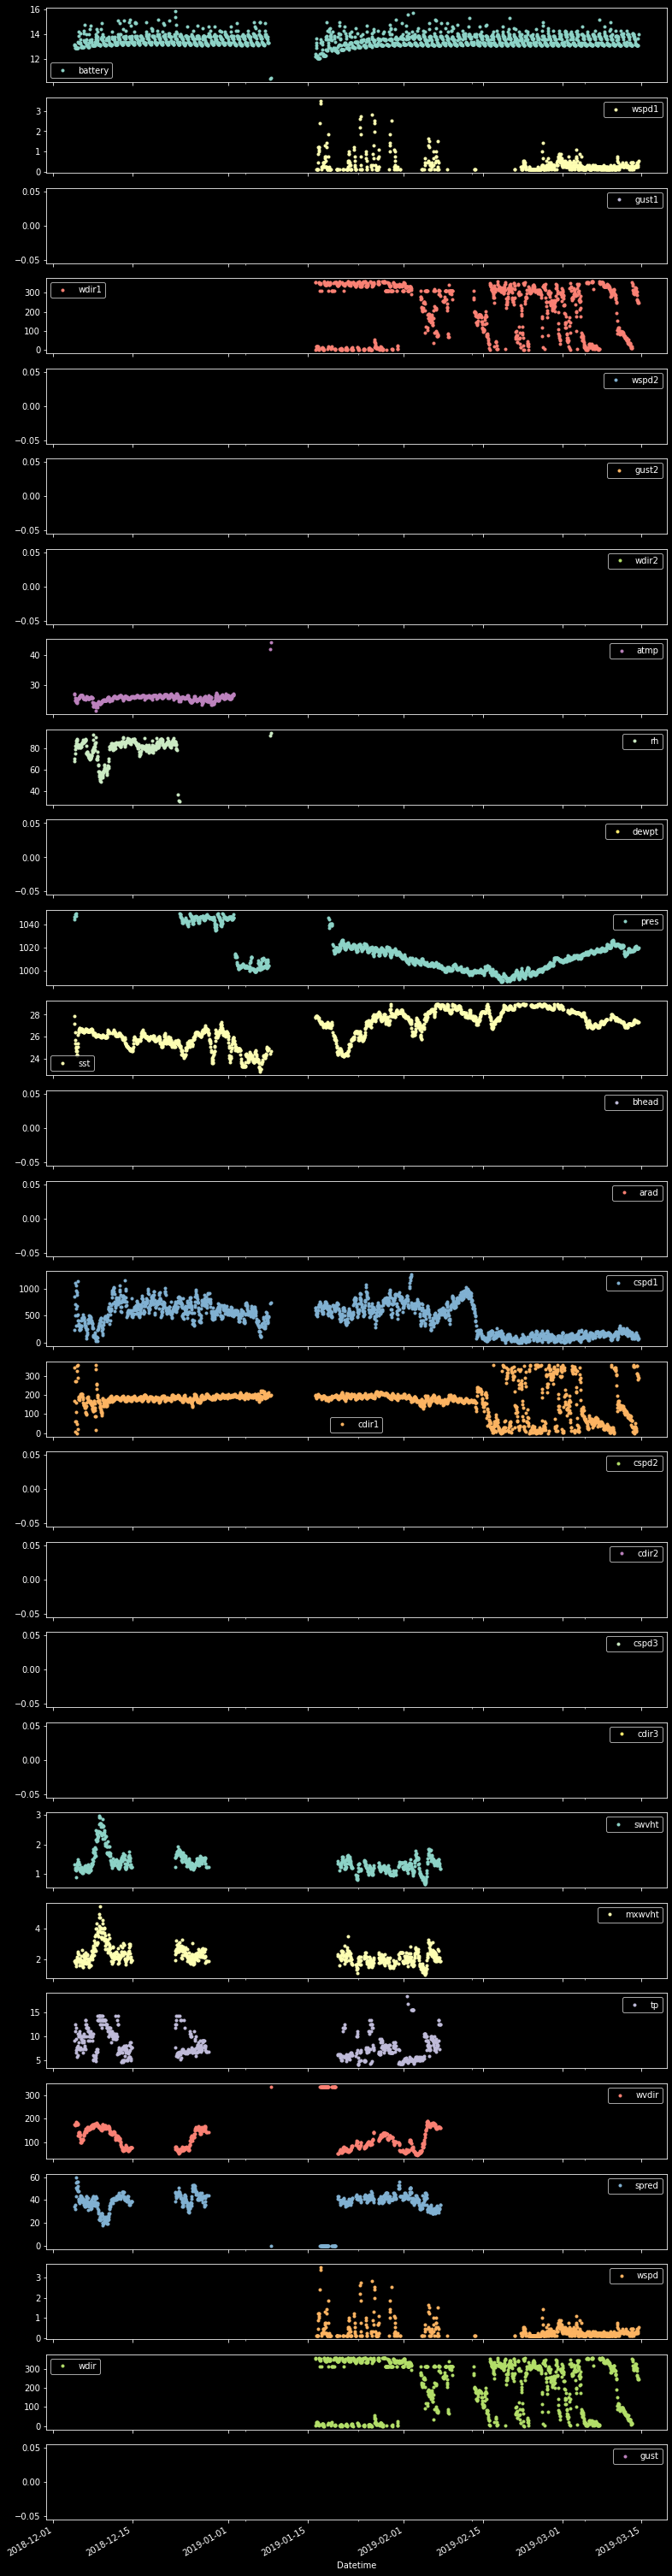

In [111]:
itaoca_filtered.plot(subplots=True,marker='.',ls='none',figsize=(13,60));

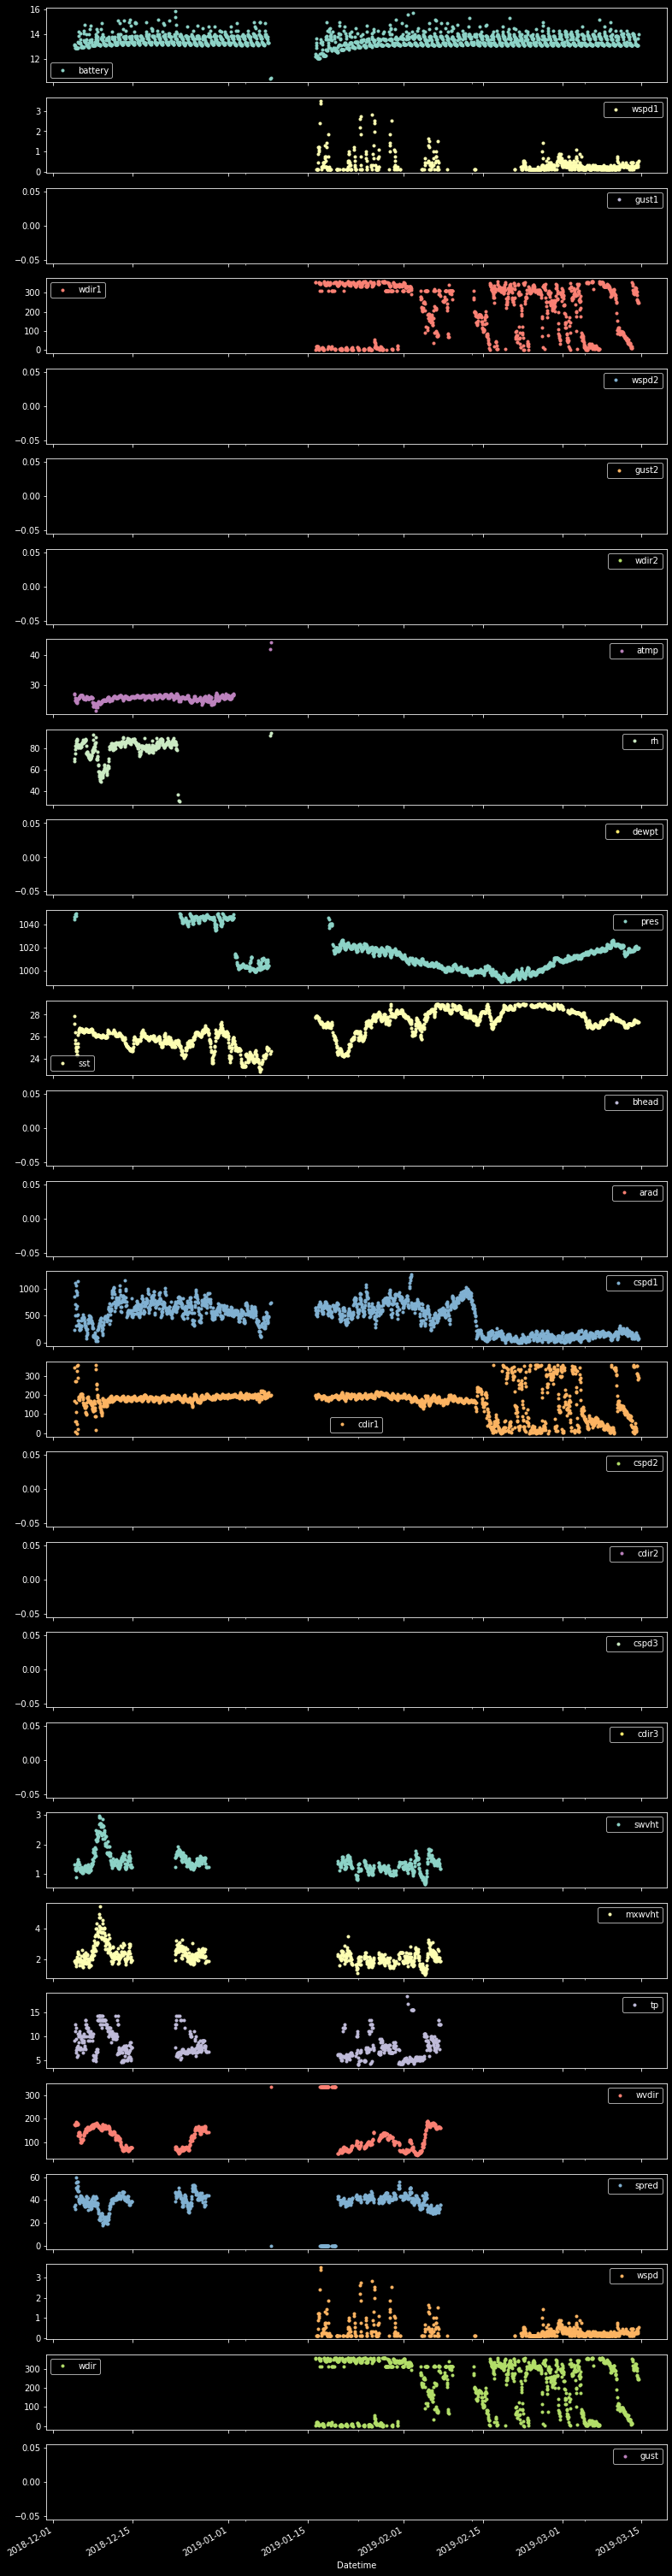

In [97]:
itaoca_filtered.plot(subplots=True,marker='.',ls='none',figsize=(13,60));

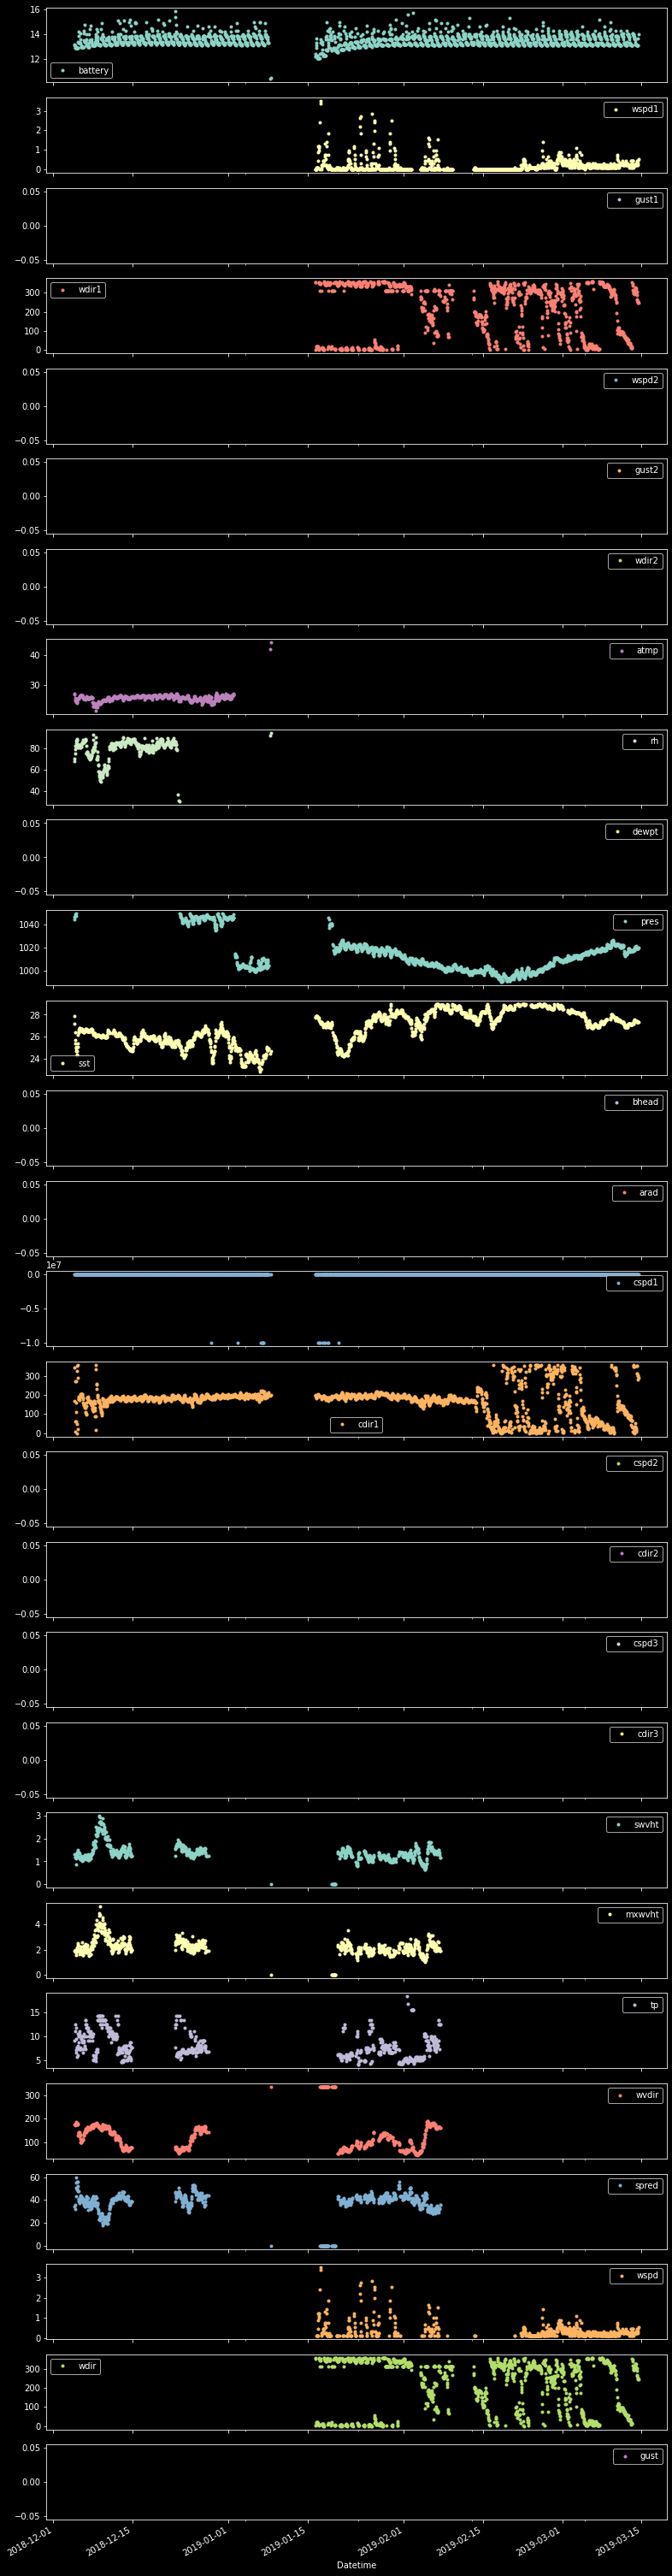

In [63]:
itaoca_filtered.plot(subplots=True,marker='.',ls='None',figsize=(13,60));

In [65]:
qc_itaoca.flag.loc['2019-01-15':]

,battery,wspd1,gust1,wdir1,wspd2,gust2,wdir2,atmp,rh,dewpt,...,cspd3,cdir3,swvht,mxwvht,tp,wvdir,spred,wspd,wdir,gust
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-04 18:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-04 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-04 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-04 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-04 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-14 07:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-03-14 08:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-03-14 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
qc_itaoca.plot_comparison(parameter='swvht',
                   ylim=[-1,5],
                   plot_type='plotly')